# Correlation with clinical outcome

The evaluation of the merged Palma-Ikonomi models focuses on their ability to predict clinical outcomes for patients with specific mutations. Palma et al. has connected their network to three cancer hallmark phenotypes: apoptosis, differentiation and proliferation. In addition, an integrated network score was defined as subtracting the value of apoptosis and differentiation from the value of the proliferation to reflect the malignancy of the cancer. The phenotype scores were then used as a proxy of the prediction power of the model to patients’ clinical outcomes.

In [1]:
model1name = "Palma2021"
model2name = "Ikonomi2020"

In [2]:
import ginsim
import biolqm
import maboss
import pypint
import numpy as np
import pandas as pd
from colomoto_jupyter import tabulate # for fixpoint table display
from itertools import combinations  # for iterating over sets
import matplotlib.pyplot as plt # for modifying plots
from scipy.stats import pearsonr # for calculating the pearson correlation
from rpy2.robjects.packages import importr
from rpy2.robjects import IntVector
from rpy2.robjects.vectors import ListVector
from rpy2 import robjects
from rpy2.robjects import conversion
from rpy2.robjects.conversion import localconverter
from rpy2.robjects import pandas2ri
boolnet = importr("BoolNet")
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.gridspec import GridSpec
import matplotlib.patches as patches
import matplotlib.colors as colors

This notebook has been executed using the docker image `colomoto/colomoto-docker:2024-03-01`

In [9]:
merged_and_name = "../Models/merged_and_" + model1name + "_" + model2name
merged_inhibitor_wins_name = "../Models/merged_inhibitor_wins_" + model1name + "_" + model2name
merged_or_name = "../Models/merged_or_" + model1name + "_" + model2name

# load the network
merged_and = boolnet.loadNetwork(merged_and_name + ".txt")
merged_inhibitor_wins = boolnet.loadNetwork(merged_inhibitor_wins_name + ".txt")
merged_or = boolnet.loadNetwork(merged_or_name + ".txt")

# get the attractor states
attr_and = boolnet.getAttractors(merged_and)
attr_inhibitor_wins = boolnet.getAttractors(merged_inhibitor_wins)
attr_or = boolnet.getAttractors(merged_or)

## Validation against previous Palma 2021 results
### Blast percentage
>We next evaluated whether we could use these models to infer some clinical outcomes of patients carrying mutations in NPM1 and/or DNMT3A and/or FLT3. To this end we made use of the clinical information provided by Papaemmanuil et al. reporting the impact of somatic mutations on overall survival and we compared the mutation-specific hazard ratios with the predictions of our models. As a proxy for the predictive power of our model, we defined the “integrated network phenotype” score, which is calculated by subtracting from the activation value of the phenotype “proliferation” the values of “apoptosis” and “differentiation”.

### Clinical outcomes
>We next investigated the prognostic power of our model by comparing it with additional clinical features derived from the AML TGCA dataset. Specifically, we compared the mutation-specific peripheral blood (PB) and bone marrow (BM) blast percentages with the predictions of our models.
   
Mutation and clinical data are downloaded from the [NIH GDC website](https://gdc.cancer.gov/about-data/publications/laml_2012):
1. [Supplemental Table 06: All somatic mutations with annotation and readcounts from DNA and RNA sequencing](SupplementalTable06.tsv)
2. [Patient Clinical Data](https://portal.gdc.cancer.gov/files/c07a64a0-7588-4653-95ef-982b41a1a804?aeTable_offset=20)

In [35]:
def simulation(model_file):
    model = biolqm.load(model_file)
    
    # set the fix value for the simulations
    wt = biolqm.perturbation(model, "FLT3%0 DNMT3A%1 NPM1%1")
    flt3 = biolqm.perturbation(model, "FLT3%1 DNMT3A%1 NPM1%1")
    npm1 = biolqm.perturbation(model, "FLT3%0 DNMT3A%1 NPM1%0")
    dnmt3a = biolqm.perturbation(model, "FLT3%0 DNMT3A%0 NPM1%1")
    npm1_dnmt3a = biolqm.perturbation(model,"FLT3%0 DNMT3A%0 NPM1%0")
    flt3_dnmt3a = biolqm.perturbation(model, "FLT3%1 DNMT3A%0 NPM1%1")
    flt3_npm1 = biolqm.perturbation(model, "FLT3%1 DNMT3A%1 NPM1%0")
    flt3_npm1_dnmt3a = biolqm.perturbation(model, "FLT3%1 DNMT3A%0 NPM1%0")

    # get the stable states
    networks = [wt,flt3,npm1,dnmt3a,npm1_dnmt3a,flt3_dnmt3a,flt3_npm1,flt3_npm1_dnmt3a]
    results = pd.DataFrame()
    for network in networks:
        fps = biolqm.fixpoints(network)
        # take average if multiple stable states exist
        results = pd.concat([results, pd.DataFrame(fps).mean().to_frame().T],ignore_index=True)
    results.index = ["wt","flt3","npm1","dnmt3a","npm1_dnmt3a","flt3_dnmt3a","flt3_npm1","flt3_npm1_dnmt3a"]
    
    # calculate the phenotype scores
    results['APOPTOSIS'] = results['TP53'] - results['BCL2']
    results['DIFFERENTIATION'] = results['CEBPA'] + results['ETV6'] - results['MEIS1']
    results['PROLIFERATION'] = results['CCND1'] + results['SOX4'] + results['MEIS1'] + results['STAT5A']
    
    # calculate the network scores
    results['NETWORK'] = results['PROLIFERATION'] - results['APOPTOSIS'] - results['DIFFERENTIATION']
    simulation_results = results.T.sort_index()
    return simulation_results
    
def clinical_pc(simulation_results, clinical_file):
    clinical_aggr = pd.read_csv(clinical_file,index_col=0)
    clinical_results = pd.concat([clinical_aggr.T.sort_index(axis=1),simulation_results.sort_index(axis=1)])
    clinicals = ['PB_BLAST', 'BM_BLAST']
    
    clinical_pc_results = pd.DataFrame()
    
    for clinical in clinicals:
        # Extract network scores and clinical outcome values
        x = clinical_results.loc['NETWORK', :]
        y = clinical_results.loc[clinical, :]
        
        # Calculate Pearson Correlation and p-value
        clinical_pc_results.loc[clinical, 'pc'], clinical_pc_results.loc[clinical, 'p_value'] = pearsonr(x, y)
    return clinical_pc_results
    
def clinical_plot(simulation_results, clinical_file):
    clinical_aggr = pd.read_csv(clinical_file,index_col=0)
    clinical_results = pd.concat([clinical_aggr.T.sort_index(axis=1),simulation_results.sort_index(axis=1)])
    
    # Plotting scatterplots
    clinicals = ['PB_BLAST', 'BM_BLAST']
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    for i, clinical in enumerate(clinicals):
        ax = axes[i]
        # Extract network scores and clinical outcome values
        x = clinical_results.loc['NETWORK', :]
        y = clinical_results.loc[clinical, :]
        
        # Calculate Pearson Correlation and p-value
        pc, p_value = pearsonr(x, y)
    
        # Linear regression (best-fit line)
        slope, intercept = np.polyfit(x, y, 1)
        ax.plot(x, slope*x + intercept, color='purple')  # Plotting the best-fit line
        
        # Create scatterplot
        ax.scatter(x, y)
        ax.set_title(f'{clinical} vs Network score')
        ax.set_xlabel('Network score')
        ax.set_ylabel('%' + clinical)
    
            # Annotate each data point
        for j in range(len(x)):
            label = x.index[j]
            ax.annotate(label, (x.iloc[j], y.iloc[j]), textcoords="offset points", xytext=(0,7), ha='center')
    
        
        # Annotate Pearson Correlation and p-value
        ax.text(0.95, 0.05, f'PC: {pc:.2f}\np-value: {p_value:.2e}',
                transform=ax.transAxes, horizontalalignment='right')
        
    plt.tight_layout()
    plt.show()

def clinical_plot_pb(simulation_results, clinical_file):
    clinical_aggr = pd.read_csv(clinical_file,index_col=0)
    clinical_results = pd.concat([clinical_aggr.T.sort_index(axis=1),simulation_results.sort_index(axis=1)])
    
    # Plotting scatterplots
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))

    # Extract network scores and clinical outcome values
    x = clinical_results.loc['NETWORK', :]
    y = clinical_results.loc['PB_BLAST', :]
    
    # Calculate Pearson Correlation and p-value
    pc, p_value = pearsonr(x, y)

    # Linear regression (best-fit line)
    slope, intercept = np.polyfit(x, y, 1)
    ax.plot(x, slope*x + intercept, color='purple')  # Plotting the best-fit line
    
    # Create scatterplot
    ax.scatter(x, y)
    ax.set_title('Blast percentage vs Network score')
    ax.set_xlabel('Network score')
    ax.set_ylabel('Blast percentage')

    # Annotate each data point
    for j in range(len(x)):
        label = x.index[j]
        ax.annotate(label, (x.iloc[j], y.iloc[j]), textcoords="offset points", xytext=(0,7), ha='center')

    
    # Annotate Pearson Correlation and p-value
    ax.text(0.95, 0.05, f'PC: {pc:.2f}\np-value: {p_value:.2e}',
            transform=ax.transAxes, horizontalalignment='right')
        
    plt.tight_layout()
    plt.show()

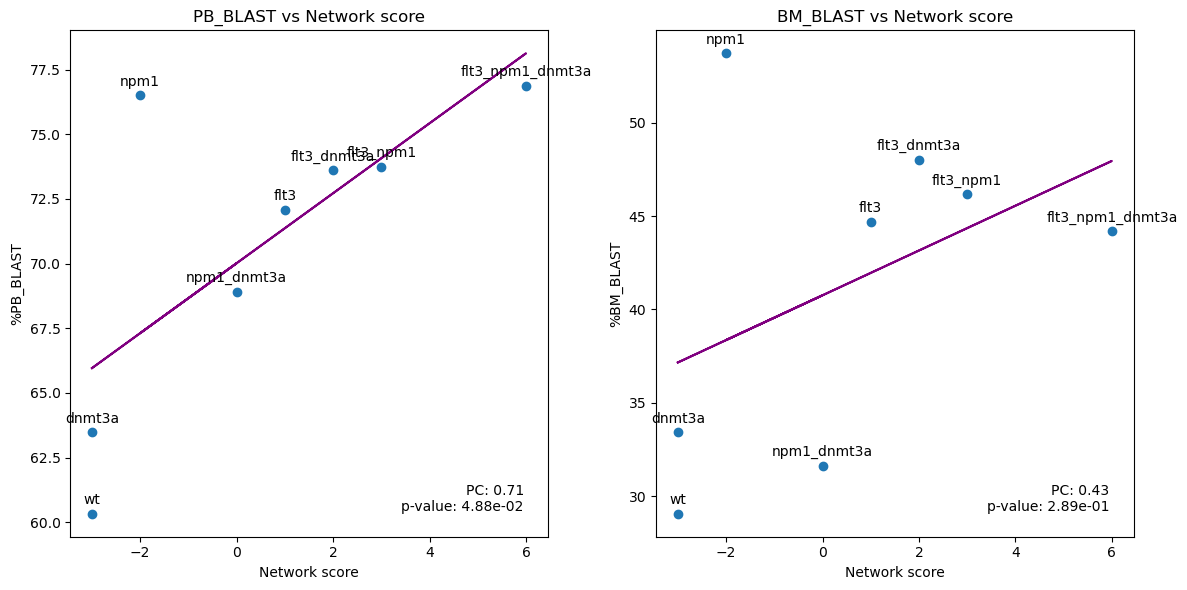

In [36]:
# Palma 2021's results
simulation_results_palma = simulation('Palma2021_nophe.sbml')
clinical_pc_palma = clinical_pc(simulation_results_palma, 'clinical.csv')
clinical_plot(simulation_results_palma, 'clinical.csv')

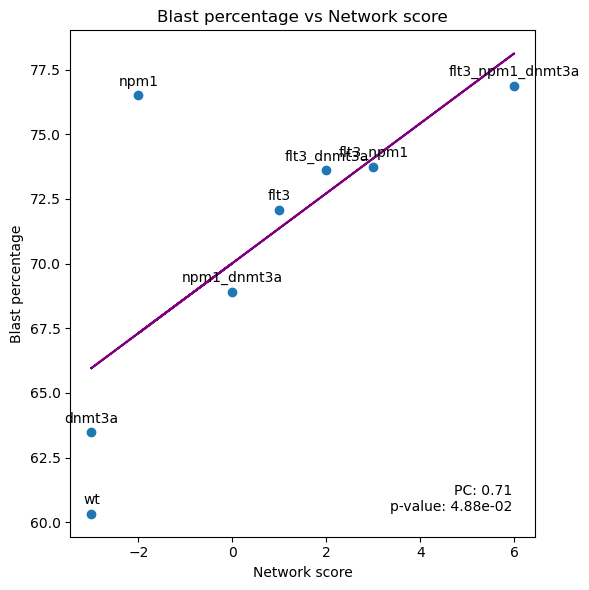

In [37]:
clinical_plot_pb(simulation_results_palma, 'clinical.csv')

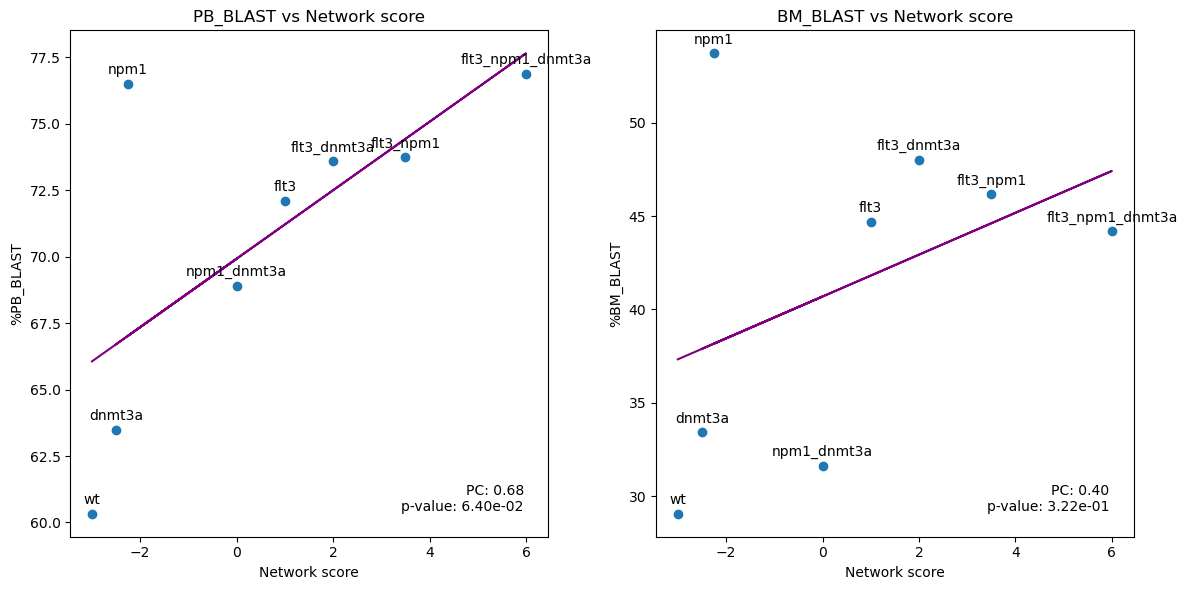

In [38]:
# Merged rules using 'OR'
simulation_results_or = simulation('merged_or.sbml')
clinical_pc_or = clinical_pc(simulation_results_or, 'clinical.csv')
clinical_plot(simulation_results_or, 'clinical.csv')

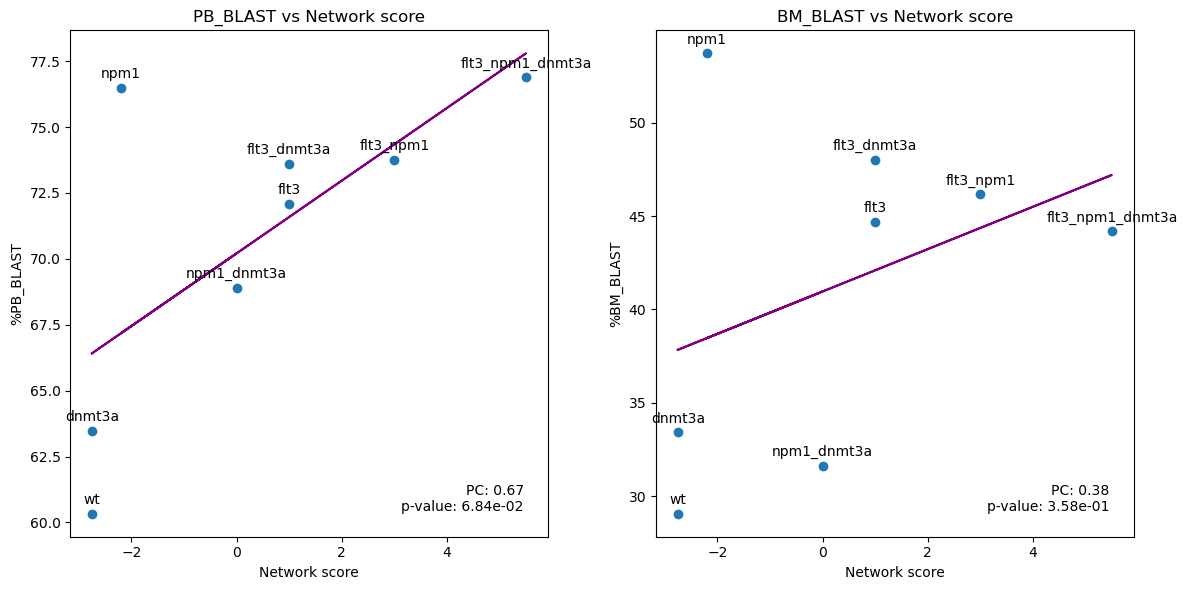

In [39]:
# Merged rules using 'Inhibitor wins'
simulation_results_inhibitor_wins = simulation('merged_inhibitor_wins.sbml')
clinical_pc_inhibitor_wins = clinical_pc(simulation_results_inhibitor_wins, 'clinical.csv')
clinical_plot(simulation_results_inhibitor_wins, 'clinical.csv')

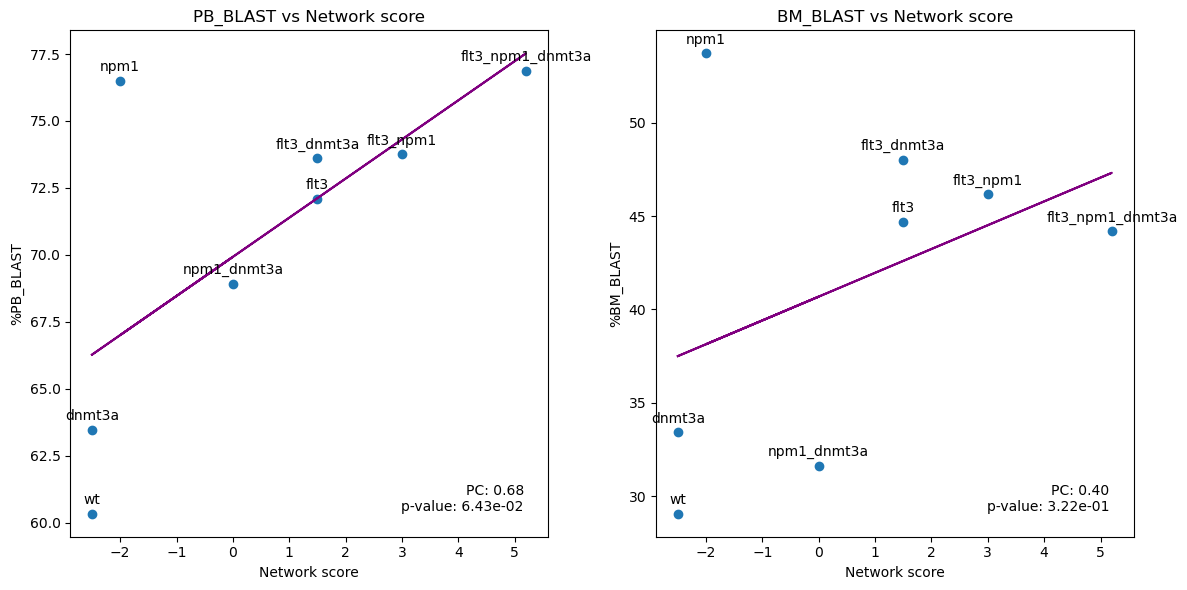

In [40]:
# Merged rules using 'AND'
simulation_results_and = simulation('merged_and.sbml')
clinical_pc_and = clinical_pc(simulation_results_and, 'clinical.csv')
clinical_plot(simulation_results_and, 'clinical.csv')

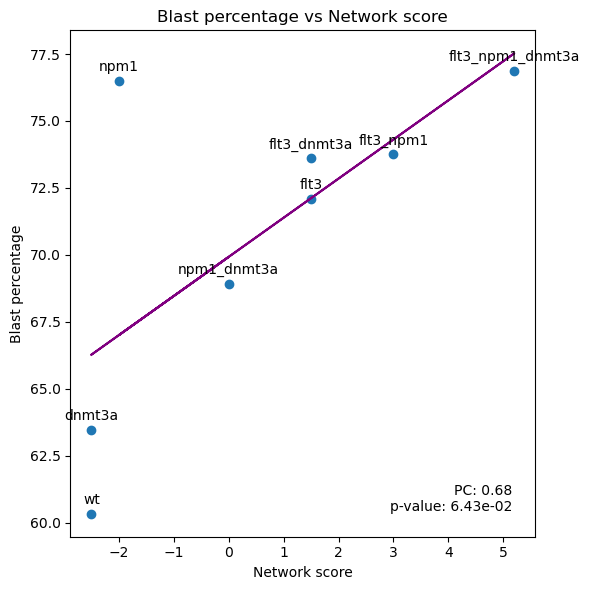

In [41]:
clinical_plot_pb(simulation_results_and, 'clinical.csv')

In [44]:
display_side_by_side([clinical_pc_palma, clinical_pc_or, clinical_pc_inhibitor_wins, clinical_pc_and], titles=titles)

,pc,p_value
PB_BLAST,0.709216,0.048842
BM_BLAST,0.428700,0.289242
,pc,p_value
PB_BLAST,0.679161,0.063973
BM_BLAST,0.402807,0.322457
,pc,p_value
PB_BLAST,0.671175,0.068407
BM_BLAST,0.376352,0.358142
,pc,p_value
PB_BLAST,0.678583,0.064288


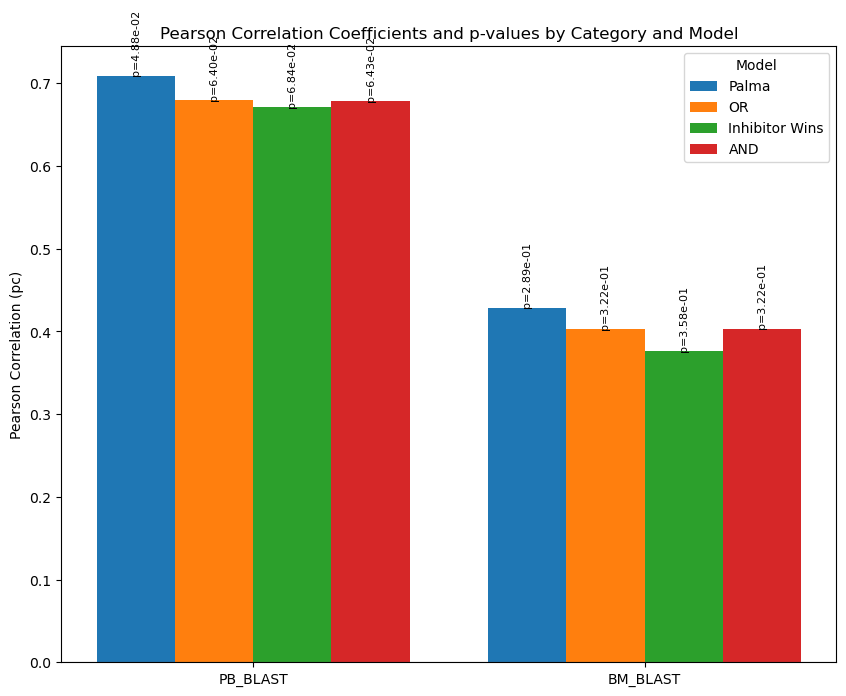

In [132]:
fig, ax = plt.subplots(figsize=(10, 8))

categories = clinical_pc_palma.index
x = np.arange(len(categories))  # the label locations
width = 0.2  # the width of the bars

# Plot each dataframe
plot_df(clinical_pc_palma, ax, -1.5, 'Palma')
plot_df(clinical_pc_or, ax, -0.5, 'OR')
plot_df(clinical_pc_inhibitor_wins, ax, 0.5, 'Inhibitor Wins')
plot_df(clinical_pc_and, ax, 1.5, 'AND')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Pearson Correlation (pc)')
ax.set_title('Pearson Correlation Coefficients and p-values by Category and Model')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.axhline(0, color='grey', linewidth=0.8)
ax.legend(title='Model')

plt.show()

**There result is slightly worse compared with Palma's for both peripheral blood (PB) blast cell percentage and bone marrow (BM) blast cell percentage.**  

## Using the ProxPath to define phenotype scores

An algorithm that, given a set of proteins, estimates its regulatory impact over phenotypes and pathways annotated in SIGNOR.
   
I have checked that nodes derived from the ProxPath cover all nodes in Palma's calculation function.

In [177]:
%run '../ProxPath.ipynb'

# the Palma results
nodes_palma = getnodes("Palma2021_nophe.sbml")
pheno_palma = proxpath(nodes_palma)
simulation_results_palma_new = pheno_scores(simulation_results_palma, pheno_palma)
simulation_results_palma_new.loc['NETWORK'] = simulation_results_palma_new.loc['PROLIFERATION'] - simulation_results_palma_new.loc['APOPTOSIS'] - simulation_results_palma_new.loc['DIFFERENTIATION']
hazard_ratio_pc_palma = hazard_ratio_pc(simulation_results_palma_new, 'Hazard Ratio for Death.csv')
clinical_pc_palma = clinical_pc(simulation_results_palma_new, 'clinical.csv')


# the 'OR' results
nodes_or = getnodes("merged_or.sbml")
pheno_or = proxpath(nodes_or)
simulation_results_or_new = pheno_scores(simulation_results_or, pheno_or)
simulation_results_or_new.loc['NETWORK'] = simulation_results_or_new.loc['PROLIFERATION'] - simulation_results_or_new.loc['APOPTOSIS'] - simulation_results_or_new.loc['DIFFERENTIATION']
hazard_ratio_pc_or = hazard_ratio_pc(simulation_results_or_new, 'Hazard Ratio for Death.csv')
clinical_pc_or = clinical_pc(simulation_results_or_new, 'clinical.csv')

# the 'Inhibitor wins' results
nodes_in = getnodes("merged_inhibitor_wins.sbml")
pheno_in = proxpath(nodes_in)
simulation_results_inhibitor_wins_new = pheno_scores(simulation_results_inhibitor_wins, pheno_in)
simulation_results_inhibitor_wins_new.loc['NETWORK'] = simulation_results_inhibitor_wins_new.loc['PROLIFERATION'] - simulation_results_inhibitor_wins_new.loc['APOPTOSIS'] - simulation_results_inhibitor_wins_new.loc['DIFFERENTIATION']
hazard_ratio_pc_in = hazard_ratio_pc(simulation_results_inhibitor_wins_new, 'Hazard Ratio for Death.csv')
clinical_pc_in = clinical_pc(simulation_results_inhibitor_wins_new, 'clinical.csv')

# the 'AND' results
nodes_and = getnodes("merged_and.sbml")
pheno_and = proxpath(nodes_and)
simulation_results_and_new = pheno_scores(simulation_results_and, pheno_and)
simulation_results_and_new.loc['NETWORK'] = simulation_results_and_new.loc['PROLIFERATION'] - simulation_results_and_new.loc['APOPTOSIS'] - simulation_results_and_new.loc['DIFFERENTIATION']
hazard_ratio_pc_and = hazard_ratio_pc(simulation_results_and_new, 'Hazard Ratio for Death.csv')
clinical_pc_and = clinical_pc(simulation_results_and_new, 'clinical.csv')

In [180]:
pheno_or

,EndPathways,QueryNode,EndNode,Path_String,relations_path,Path_Score,Path_Length,Final_Effect,Effect,n,mean,sd,zscore,Closest_Gene
2894,APOPTOSIS,TP53,APOPTOSIS,TP53-->APOPTOSIS,SIGNOR-255678,0.300,1,1,up-regulates,75493,1.737625,0.526944,-2.728233,TP53
2896,APOPTOSIS,MAPK1,APOPTOSIS,MAPK1-->FOS-->JUN--|APOPTOSIS,SIGNOR-262996;SIGNOR-252087;SIGNOR-256560,0.578,3,-1,down-regulates,75493,1.737625,0.526944,-2.200663,MAPK1
2913,APOPTOSIS,BCL2,APOPTOSIS,BCL2--|APOPTOSIS,SIGNOR-249611,0.300,1,-1,down-regulates,75493,1.737625,0.526944,-2.728233,BCL2
2918,APOPTOSIS,FOXO3,APOPTOSIS,FOXO3-->APOPTOSIS,SIGNOR-217887,0.300,1,1,up-regulates,75493,1.737625,0.526944,-2.728233,FOXO3
2946,APOPTOSIS,MAPK1,APOPTOSIS,MAPK1--|FOXO-->APOPTOSIS,SIGNOR-252958;SIGNOR-252939,0.604,2,-1,down-regulates,75493,1.737625,0.526944,-2.151321,MAPK1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54562,PROLIFERATION,MAPK1,PROLIFERATION,MAPK1--|FOXO--|PROLIFERATION,SIGNOR-252958;SIGNOR-252938,0.604,2,1,up-regulates,107507,1.681607,0.506006,-2.129632,MAPK1
54621,PROLIFERATION,RB1,PROLIFERATION,RB1--|PROLIFERATION,SIGNOR-262533,0.300,1,-1,down-regulates,107507,1.681607,0.506006,-2.730415,RB1
54650,PROLIFERATION,AKT1,PROLIFERATION,AKT1--|RAC1-->PROLIFERATION,SIGNOR-252576;SIGNOR-255648,0.587,2,-1,down-regulates,107507,1.681607,0.506006,-2.163228,AKT1
54681,PROLIFERATION,MTOR,PROLIFERATION,MTOR-->AKT1-->MTORC1-->PROLIFERATION,SIGNOR-170604;SIGNOR-255844;SIGNOR-256063,0.672,3,1,up-regulates,107507,1.681607,0.506006,-1.995246,MTOR


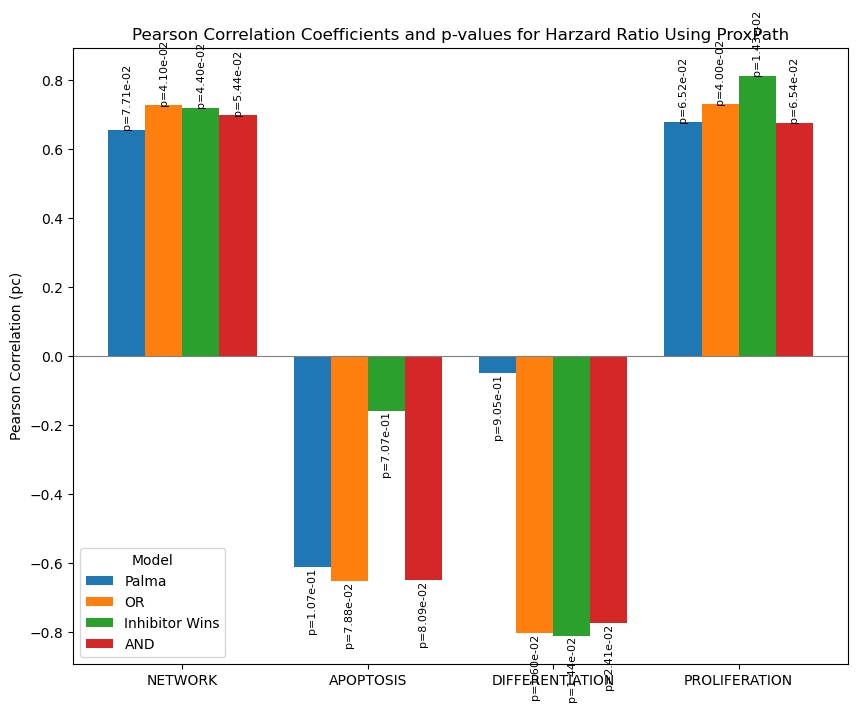

In [173]:
fig, ax = plt.subplots(figsize=(10, 8))

categories = hazard_ratio_pc_palma.index
x = np.arange(len(categories))  # the label locations
width = 0.2  # the width of the bars

def plot_df(df, ax, position, label):
    bars = ax.bar(x + position * width, df['pc'], width, label=label)
    # Annotate p-value on each bar
    for bar, p_value in zip(bars, df['p_value']):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'p={p_value:.2e}', 
                ha='center', va='bottom' if bar.get_height() > 0 else 'top', fontsize=8, rotation=90)

# Plot each dataframe
plot_df(hazard_ratio_pc_palma, ax, -1.5, 'Palma')
plot_df(hazard_ratio_pc_or, ax, -0.5, 'OR')
plot_df(hazard_ratio_pc_inhibitor_wins, ax, 0.5, 'Inhibitor Wins')
plot_df(hazard_ratio_pc_and, ax, 1.5, 'AND')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Pearson Correlation (pc)')
ax.set_title('Pearson Correlation Coefficients and p-values for Harzard Ratio Using ProxPath')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.axhline(0, color='grey', linewidth=0.8)
ax.legend(title='Model')

plt.show()

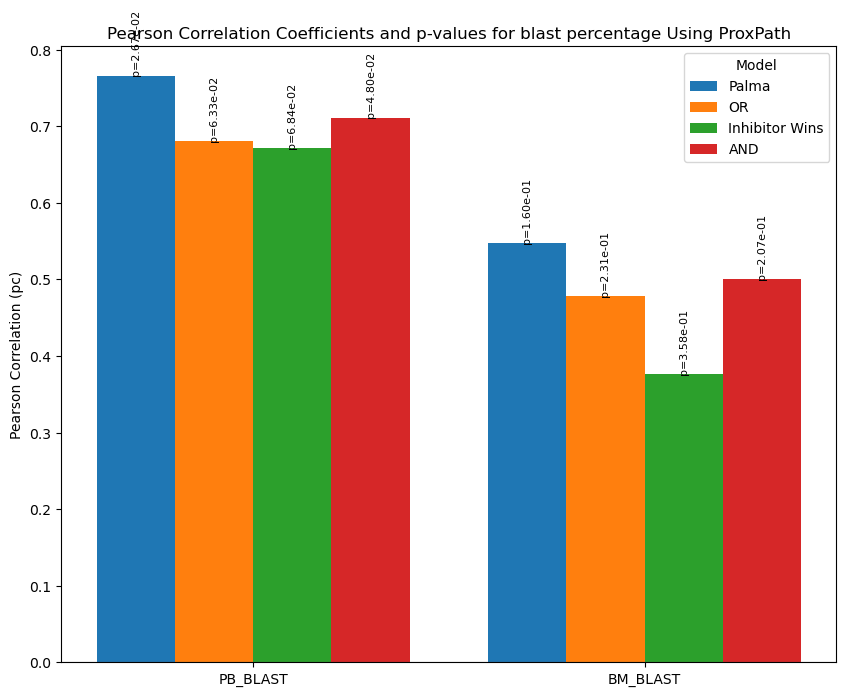

In [174]:
fig, ax = plt.subplots(figsize=(10, 8))

categories = clinical_pc_palma.index
x = np.arange(len(categories))  # the label locations
width = 0.2  # the width of the bars

# Plot each dataframe
plot_df(clinical_pc_palma, ax, -1.5, 'Palma')
plot_df(clinical_pc_or, ax, -0.5, 'OR')
plot_df(clinical_pc_inhibitor_wins, ax, 0.5, 'Inhibitor Wins')
plot_df(clinical_pc_and, ax, 1.5, 'AND')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Pearson Correlation (pc)')
ax.set_title('Pearson Correlation Coefficients and p-values for blast percentage Using ProxPath')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.axhline(0, color='grey', linewidth=0.8)
ax.legend(title='Model')

plt.show()

## Conclusion
**Merging of the Palma et al. 2021 model and Ikonomi et al. 2020 model is feasible, but the performance against clinical data varys. (The 'AND' model is slightly better?)** 
